In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

In [4]:
train_path = 'Data/train'
val_path = 'Data/valid'


classN_train_path = train_path + "/normal/"
classA_train_path = train_path + "/adenocarcinoma/"
classL_train_path = train_path + "/large.cell.carcinoma/"
classS_train_path = train_path + "/squamous.cell.carcinoma/"
classN_valid_path = val_path + "/normal/"
classA_valid_path = val_path + "/adenocarcinoma/"
classL_valid_path = val_path + "/large.cell.carcinoma/"
classS_valid_path = val_path + "/squamous.cell.carcinoma/"

In [ ]:
mean_sizes = []

print("CLASS: NORMAL")
mean_sizes.append(get_average_image_size(classN_train_path)[0])

print("\nCLASS: A")
mean_sizes.append(get_average_image_size(classA_train_path)[0])

print("\nCLASS: L")
mean_sizes.append(get_average_image_size(classL_train_path)[0])

print("\nCLASS: S")
mean_sizes.append(get_average_image_size(classS_train_path)[0])

In [4]:
mean_sizes = np.array(mean_sizes)
out_img_size = (int(np.round(mean_sizes[:, 0].mean())), int(np.round(mean_sizes[:, 1].mean())))

print(f"Mean of all images: {out_img_size}")

Mean of all images: (305, 438)


In [5]:
out_img_dir = "Data_Cropped_and_Resized"
output_img_size = (256, 256)

crop_and_resize_images(train_path, output_img_size, out_img_dir)

error: OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.dispatch.cpp:1530: error: (-215:Assertion failed) !_src.empty() in function 'filter2D'


In [10]:
crop_and_resize_images(val_path, output_img_size, out_img_dir)


### Define class labels

In [11]:
class_mappings = {
    0: "normal",
    1: "adenocarcinoma",
    2: "large.cell.carcinoma",
    3: "squamous.cell.carcinoma"
}

### Feature Extraction

In [5]:
#train_path = "/content/drive/MyDrive/W281/Final Project/Data_Resized/train"

train_imgs, train_sobel_edges, train_labels = extract_features(train_path, detect_edges_sobel, class_mappings)
_, train_hounsfield_edges, _ = extract_features(train_path, apply_hounsfield_units, class_mappings)

error: OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/deriv.cpp:419: error: (-215:Assertion failed) !_src.empty() in function 'Sobel'


In [15]:
valid_path = "Data_Cropped_and_Resized/valid"
valid_imgs, valid_sobel_edges, valid_labels = extract_features(valid_path, detect_edges_sobel, class_mappings)
_, valid_hounsfield_edges, _ = extract_features(valid_path, apply_hounsfield_units, class_mappings)

In [34]:
import numpy as np

# Flatten the images
flattened_sobel_edges = [img.flatten() for img in valid_sobel_edges]
flattened_hounsfield_edges = [img.flatten() for img in valid_hounsfield_edges]

# Combine 
input_features = np.array([flattened_sobel_edges, flattened_hounsfield_edges])

# Transpose the array to have samples as rows and features as columns
input_features = input_features.T


In [42]:
input_features.shape

(2, 66, 65536)

### Plot features

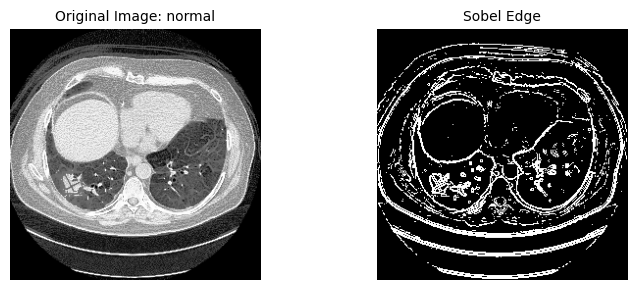

In [20]:
plot_features(valid_imgs, valid_sobel_edges, valid_labels, 0, 'Sobel Edge', class_mappings)

In [ ]:
plot_features(train_imgs, train_hounsfield_edges, train_labels, 0, "Hounsfield Unit", class_mappings)

In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC


def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)

  plt.figure(figsize=(15,5))
  colors = ['b-', 'm-']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.grid(True)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list

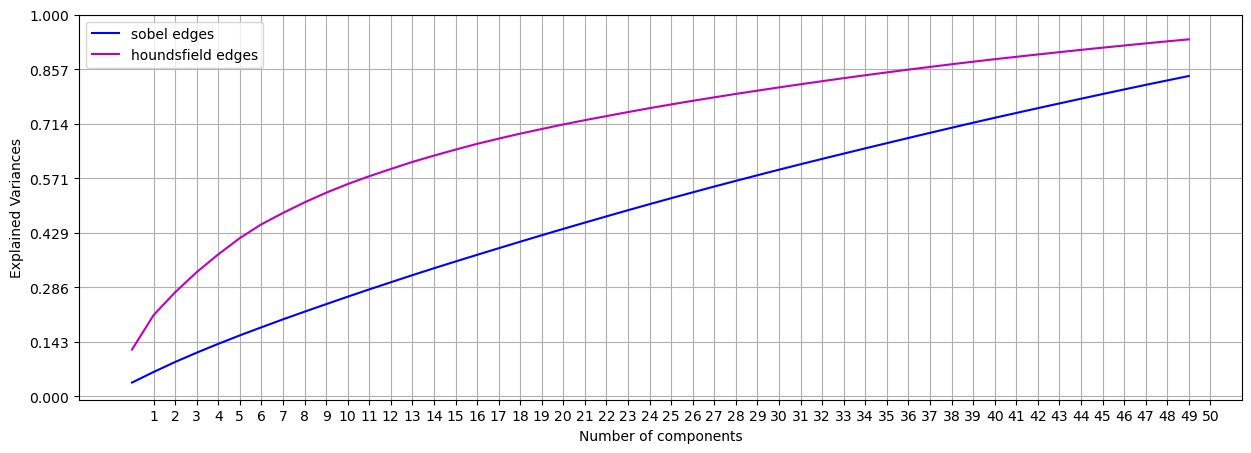

In [47]:

labels = ['sobel edges', 'houndsfield edges']

x = plot_PCA(training_features, labels, n_components=50)

In [71]:

X_sobel_pca, X_hounsfield_pca = get_PCA(input_features, n_components=48)[-1]

X_sobel_tsne, X_hounsfield_tsne = get_tsne(input_features, n_components=3)

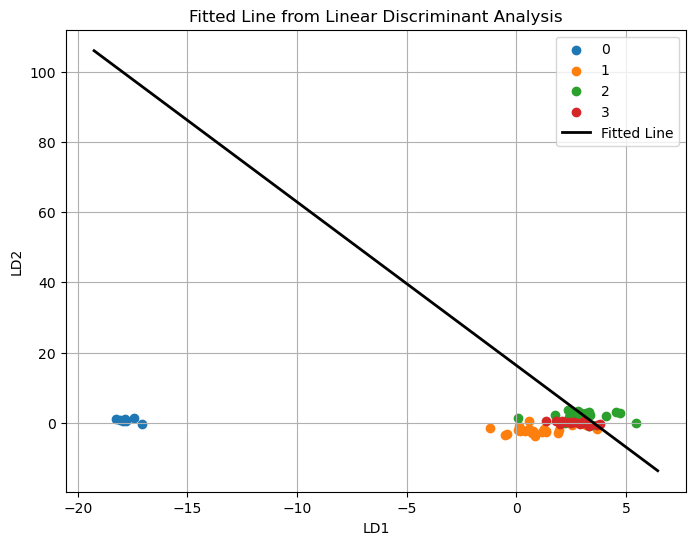

In [72]:
import numpy as np

import sklearn

import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_sobel_pca, valid_labels)

X_lda = lda.transform(X_sobel_pca)

# Step 2: Find the coefficients of the fitted line in the LDA subspace
coef_lda = lda.coef_[0]
intercept_lda = lda.intercept_[0]

plt.figure(figsize=(8, 6))

# Plot data points colored by their class labels
for label in np.unique(valid_labels):
    plt.scatter(X_lda[valid_labels == label, 0], X_lda[valid_labels == label, 1], label=label)

# Calculate the endpoints of the fitted line in the LDA subspace
x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
line_x = np.array([x_min, x_max])
line_y = -(line_x * coef_lda[0] + intercept_lda) / coef_lda[1]

plt.plot(line_x, line_y, c='black', linewidth=2, label='Fitted Line')

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Fitted Line from Linear Discriminant Analysis')
plt.legend()
plt.grid(True)
plt.show()

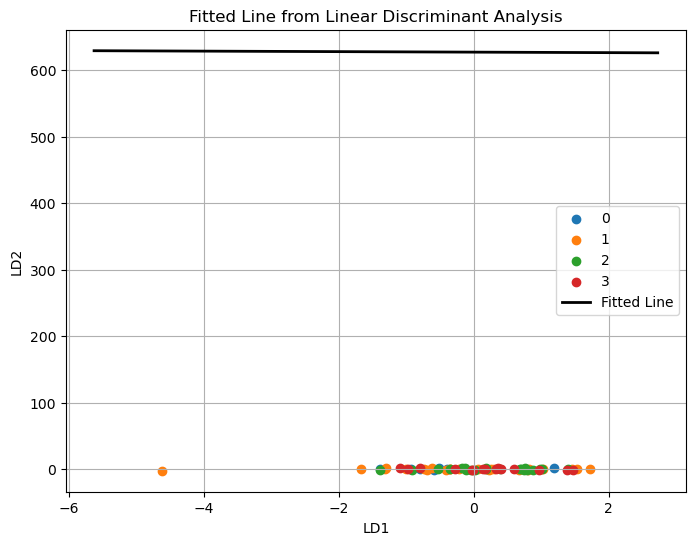

In [73]:
import numpy as np

import sklearn

import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_sobel_tsne, valid_labels)

X_lda = lda.transform(X_sobel_tsne)

# Step 2: Find the coefficients of the fitted line in the LDA subspace
coef_lda = lda.coef_[0]
intercept_lda = lda.intercept_[0]

plt.figure(figsize=(8, 6))

# Plot data points colored by their class labels
for label in np.unique(valid_labels):
    plt.scatter(X_lda[valid_labels == label, 0], X_lda[valid_labels == label, 1], label=label)

# Calculate the endpoints of the fitted line in the LDA subspace
x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
line_x = np.array([x_min, x_max])
line_y = -(line_x * coef_lda[0] + intercept_lda) / coef_lda[1]

plt.plot(line_x, line_y, c='black', linewidth=2, label='Fitted Line')

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Fitted Line from Linear Discriminant Analysis')
plt.legend()
plt.grid(True)
plt.show()